In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
import traceback
import numpy as np
import scipy.stats as ss
import itertools
from os import path
import pickle
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 13]

import pandas as pd
pd.options.display.width = 500

n_bins_default = 30
num_poly_features = 1
color_nodes = {'gmapping': 'orange', 'slam_toolbox': 'blue'}


In [3]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        df = cache_dict['df']
        p = list(cache_dict['parameter_names'])
        return df, p

In [14]:
class ModelPlot:
    def __init__(self, x, y, d, label, color, linewidth=3, linestyle=None):
        self.label = label
        self.color = color
        self.linewidth = linewidth
        self.linestyle = linestyle
        self.x = x
        self.y = y
        self.d = d

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def plot_model(model_plot_list, n_bins, ax=None, linear_regression=False, estimator=None):
    p = ax if ax is not None else plt
    for model_plot in model_plot_list:
        d_grouped_by_gs = model_plot.d.groupby(pd.cut(model_plot.d[model_plot.x.name], n_bins))
        d_grouped_by_gs_agg = d_grouped_by_gs.agg([np.mean])
        
        X_all = d_grouped_by_gs_agg[model_plot.x.name]['mean'].values
        y_all = d_grouped_by_gs_agg[model_plot.y.name]['mean'].values
        
        p.plot(
            d_grouped_by_gs_agg[model_plot.x.name]['mean'],
            d_grouped_by_gs_agg[model_plot.y.name]['mean'],
            label=model_plot.label,
            color=model_plot.color,
            linewidth=model_plot.linewidth/2,
            linestyle=model_plot.linestyle,
        )
        
        try:
            if estimator is None:
                estimator = HuberRegressor()
#             X_all = model_plot.d[model_plot.x.name].values
            X_all = X_all[:, np.newaxis]
#             X_train = X_all[0:len(X_all)//2]

#             y_all = model_plot.d[model_plot.y.name].values
#             y_train = y_all[0:len(y_all)//2]
            
#             X_test = X_all[len(X_all)//2:-1]
#             y_test = y_all[len(y_all)//2:-1]
            
            x_plot = np.linspace(X_all.min(), X_all.max())

            model = make_pipeline(PolynomialFeatures(num_poly_features), estimator)
            model.fit(X_all, y_all)
#             mse = mean_squared_error(model.predict(X_test), y_test)
            y_plot = model.predict(x_plot[:, np.newaxis])
            p.plot(
                x_plot, y_plot, 
                label=f"{model_plot.label} {type(estimator).__name__}",
                color=model_plot.color,
                linewidth=model_plot.linewidth,
                linestyle=model_plot.linestyle,
            )
        except:
#             print(traceback.format_exc())
#             print(f"could not compute estimator ({type(estimator).__name__})")
            pass
        
        if ax is not None:
            ax.set(xlabel=model_plot.x.name, ylabel=model_plot.y.name)
        else:
            plt.xlabel(model_plot.x.name)
            plt.ylabel(model_plot.y.name)


def plot_array(input_metric, output_metric):
    title = f"{input_metric.name} → {output_metric.name}, for all <max_range, fov, beta> combinations"

    X[:, 1] = 1/X[:, 1]
    mrs = sorted(list(df.laser_scan_max_range.unique()))
    fovs = sorted(list(df.laser_scan_fov_deg.unique()))
    betas = sorted(list(df.beta.unique()))
    betas_fovs = list(itertools.product(betas, fovs))

    fig, axs = plt.subplots(len(mrs), len(betas_fovs))
    for ax in axs.flat:
        ax.label_outer()
    for i, mr in enumerate(mrs):
        for j, (beta, fov) in enumerate(betas_fovs):
            plot_model(
                [
                    ModelPlot(
                        input_metric,
                        output_metric,
                        df[(df.slam_node == 'gmapping') &
                           (df.laser_scan_max_range == mr) &
                           (df.laser_scan_fov_deg == fov) &
                           (df.beta == beta)],
                        'gmapping', 'orange', linestyle='-'),
                    ModelPlot(
                        input_metric,
                        output_metric,
                        df[(df.slam_node == 'slam_toolbox') &
                           (df.laser_scan_max_range == mr) &
                           (df.laser_scan_fov_deg == fov) &
                           (df.beta == beta)],
                        'slam_toolbox', 'blue', linestyle='-'),
                ], 
                n_bins_default,
                axs[i, j],
            )
            axs[i, j].set_title(f"mr={mr}m, fov={fov}deg, beta={beta}")
            axs[i, j].sharex(axs[0, 0])
            axs[i, j].sharey(axs[0, 0])
            axs[i, j].grid(True)

    axs[0, 0].legend()
    plt.suptitle(title)
    plt.show()

In [5]:
rename_dict = {
    'trajectory_length_trajectory_length': 'trajectory_length',
    'waypoint_relative_localization_error_translation_error_final': 'translation_error',
    'waypoint_relative_localization_error_rotation_error_final': 'rotation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr',
    'waypoint_start_time': 'start_time',
}
p = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
    'environment_name',
    'slam_node',
]
m = [
    'start_time',
    'translation_error',
    'norm_translation_error',
    'rotation_error',
    'trajectory_length',
    'tgs',
    'lvr',
]
df, params = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")

df = df[df.linear_angular_update == (0.5, 0.5)]
df = df[df.trajectory_length_trajectory_length > 1]

df.rename(columns=rename_dict, inplace=True)
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df['beta'] = df['beta'].apply(lambda x: max(x))
df['norm_translation_error'] = df.translation_error / df.trajectory_length

df = df[p+m]

for c in p:
    print("{:>30}".format(c), sorted(list(df[c].unique())))

          laser_scan_max_range [3.5, 8.0, 15.0, 30.0]
            laser_scan_fov_deg [90, 180, 270, 359]
                          beta [0.0, 2.0]
              environment_name ['7A-2', 'airlab', 'fr079', 'office_b']
                     slam_node ['gmapping', 'slam_toolbox']


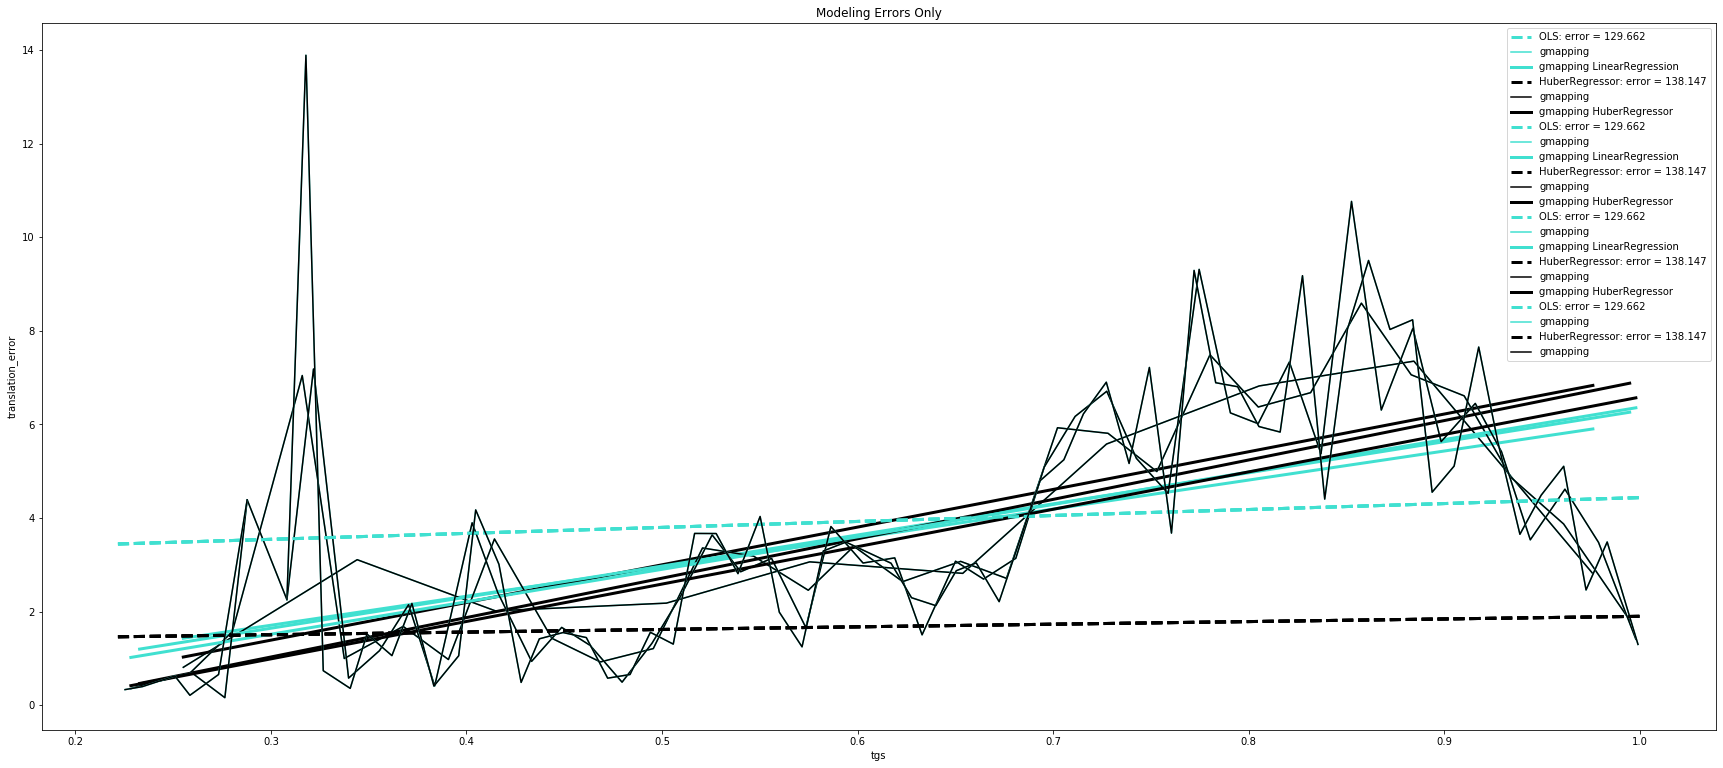

In [6]:
color_nodes = {'gmapping': 'orange', 'slam_toolbox': 'blue'}

mr = 3.5
fov = 90
beta = 2.0
slam_node = "gmapping"

df_1 = df[(df.laser_scan_max_range == mr) &
          (df.laser_scan_fov_deg == fov) &
          (df.beta == beta) &
          (df.slam_node == slam_node)
         ]

X_all = df_1.tgs.values
X_all = X_all[:, np.newaxis]
y_all = df_1.translation_error.values

X_train = X_all[0:len(X_all)//2]
X_test = X_all[len(X_all)//2:-1]

y_train = y_all[0:len(y_all)//2]
y_test = y_all[len(y_all)//2:-1]


estimators = [('OLS', LinearRegression()),
#               ('Theil-Sen', TheilSenRegressor(random_state=42)),
#               ('RANSAC', RANSACRegressor(random_state=42)),
              ('HuberRegressor', HuberRegressor())]
colors = {'OLS': 'turquoise', 'HuberRegressor': 'black'}
# colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold', 'RANSAC': 'lightgreen', 'HuberRegressor': 'black'}
linestyle = {'OLS': '--', 'HuberRegressor': '--'}
# linestyle = {'OLS': '--', 'Theil-Sen': '--', 'RANSAC': '--', 'HuberRegressor': '--'}
lw = 3

x_plot = np.linspace(X_all.min(), X_all.max())
title = 'Modeling Errors Only'
# plt.plot(X_train[:, 0], y_train, 'b+', ms=0.75)

for n_bins in [10, 30, 50, 70]:
    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(num_poly_features), estimator)
        model.fit(X_train, y_train)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(x_plot, y_plot, color=colors[name], linestyle=linestyle[name], linewidth=lw, label='%s: error = %.3f' % (name, mse))

        plot_model(
            [
                ModelPlot(
                    df.tgs,
                    df.translation_error,
                    df[(df.slam_node == slam_node) &
                       (df.laser_scan_max_range == mr) &
                       (df.laser_scan_fov_deg == fov) &
                       (df.beta == beta)],
                    slam_node, colors[name], linestyle='-'),
            ], 
            n_bins,
            estimator=estimator,
        )

    
    
legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
legend = plt.legend(loc='upper right', frameon=False, title=legend_title, prop=dict(size='x-small'))
# plt.xlim(-4, 10.2)
# plt.ylim(0, 3)
plt.title(title)
plt.legend()
plt.show()


In [10]:
# plot_array(df.tgs, df.norm_translation_error)

In [13]:
plot_array(df.lvr, df.norm_translation_error)

NameError: name 'X' is not defined

In [ ]:
plot_array(df.start_time, df.norm_translation_error)